In [97]:
import numpy as np
import pandas as pd
import statsmodels.tsa.seasonal as seasonal
from statsmodels.tsa.statespace.sarimax import SARIMAX


import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [190]:
data=pd.read_csv('AMZN.csv')

In [191]:
data['Date']=pd.to_datetime(data['Date'])
data.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Adj Close            float64
Volume                 int64
ma7                  float64
ma21                 float64
26ema                float64
12ema                float64
MACD                 float64
20sd                 float64
upper_band           float64
lower_band           float64
ema                  float64
momentum             float64
Fourier              float64
ARIMA                float64
Close                float64
labels               float64
dtype: object

In [192]:
data.head(3)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.250000,NaN


In [193]:
data_index=data.copy()
data_index.index=pd.DatetimeIndex(data['Date'])

In [195]:
ts_components=seasonal.seasonal_decompose(data_index['Adj Close'],model='additive',period=365)

In [196]:
def plot_seasonal_decompose(input_val,components='all',figsize=(15,4)):
    """
    plot components of time-series (seasonality, redidual noise, trend)
    
    inputs
    input_val: the result returned by seasonal_decompose function
    components: if components= 'all' --> all components should be plotted, 
                otherwise --> only plot specified components.
    figsize: the size of figure to plot in  
    """
    if type(components) == str and components != 'all':
        components=components.split()
        
    all_cases=('trend', 'seasonal', 'resid')  
    if components=='all': components=all_cases   
    invalid = [x for x in components if x not in all_cases]
    if invalid:
        raise ValueError("Invalid input {}.".format(invalid))
    
    to_plot=set(components).intersection(all_cases)
    #plot original data as well
    to_plot.add('observed')
    for x in to_plot:
        plt.figure(figsize=figsize)
        plt.plot(getattr(input_val,x))
        plt.title(x)
        plt.xlabel('Years',fontsize=16)
        plt.ylabel('value',fontsize=16)
        plt.grid()
        if x is 'resid':
            plt.axhline(y=0, color='black', linestyle='--',linewidth=2)
        if x is 'observed':
            plt.vlines(datetime.date(2016,4,20), 0, 1500, linestyles='--', colors='black',linewidth=2, label='Train/Test data cut-off')
        plt.show()

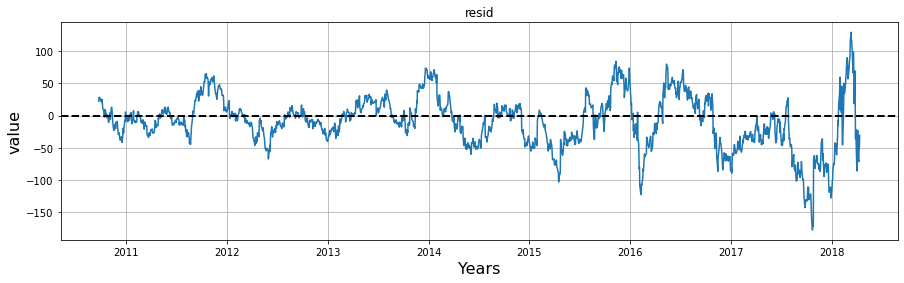

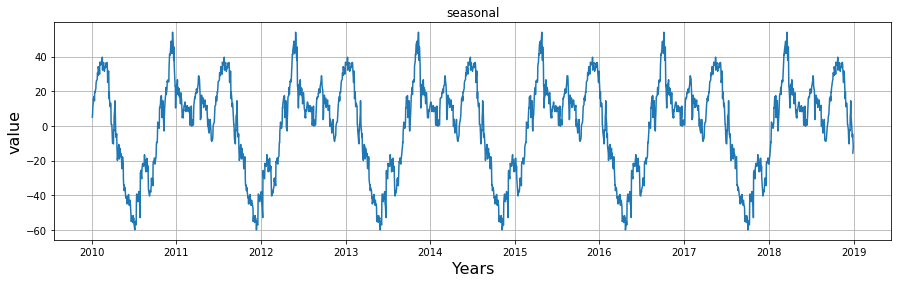

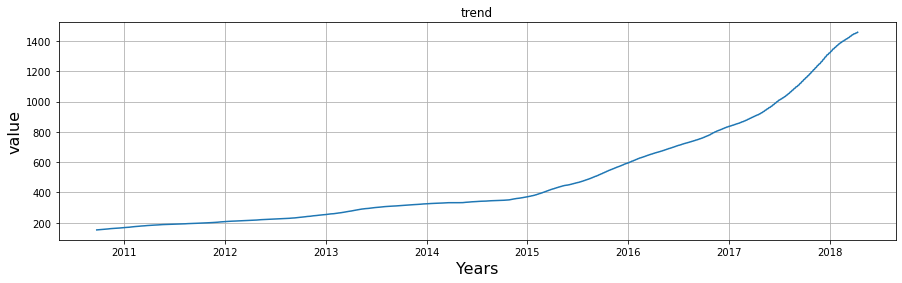

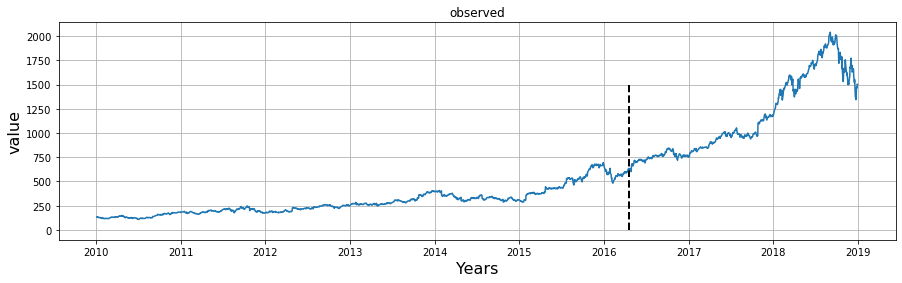

In [197]:
plot_seasonal_decompose(ts_components)

In [198]:
df=data.copy()

data has a positive trend and is seasonal. To further explore data, we will first use rolling window to better detect the movement of stock over periods of time instead of focusing on instant changes.

## Fourier Transform


In [273]:
# Create 7 and 21 days Moving Average
df['ma7'] = df['Close'].rolling(window = 7).mean()
df['ma30'] = df['Close'].rolling(window = 30).mean()

#Create Bollinger Bands
df['20sd'] = df['Close'].rolling(window = 20).std()
df['upper_band'] = df['Close'].rolling(window = 20).mean() + (df['20sd']*2)
df['lower_band'] = df['Close'].rolling(window = 20).mean() - (df['20sd']*2)

In [274]:
def plot_technical_indicators(dataset, last_days):
    """
    input
        dataset (pd.dataframe): the dataset containing all the columns we want to plot
        last_days (int) : plot the data for the last "last_days" days
    """
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()
    
    # Plot second subplot
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.legend()
    plt.show()

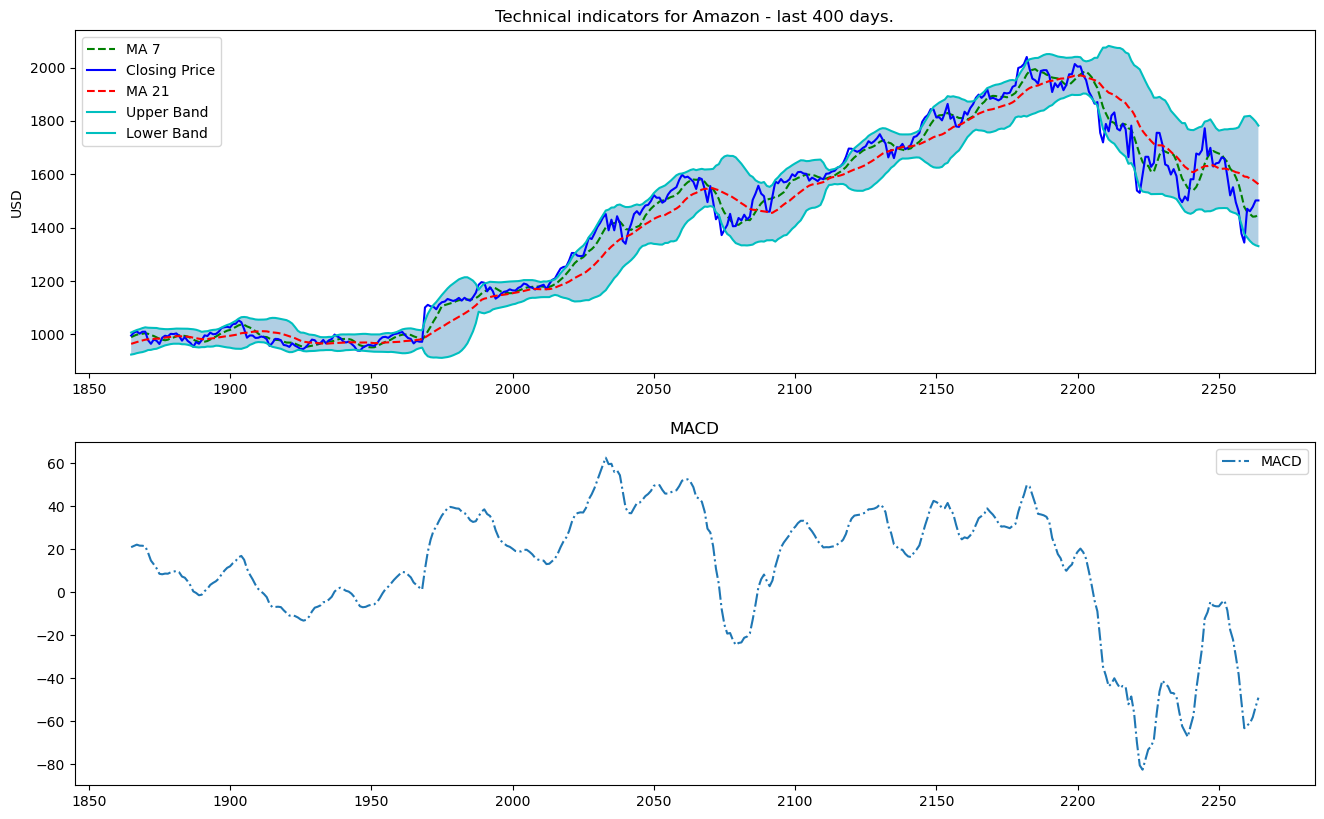

In [275]:
plot_technical_indicators(df, 400)

another approach to detect seasonality and come up with a quick albeit, probably low quality predictive model for TS is fourier transform

In [276]:
def get_fourier(data,column):
    """
     calculates the fast fourier transform
     
     input
     data (pd.DataFrame): initial dataframe
     column: on which column Fourier transform should be applied
     
     output
     df_fft (pd.DataFrame): initial dataframe + calculated fourier transform+ absolure + angle 
     
    """
    if 'Date' not in data.columns:
        data=data.reset_index()
        if 'Date' not in data.columns:
            raise ValueError('Input data should have  a Date column or DateTimeIndex.')
            
    df_fft=data[['Date',column]]
    fft_result=np.fft.fft(np.asarray(df_fft[column].tolist()))
    df_fft['fft']=fft_result
    df_fft['absolute']=np.abs(df_fft['fft'])
    df_fft['angle']=np.angle(df_fft['fft'])
    return df_fft

fft_result=get_fourier(df,'Close')

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


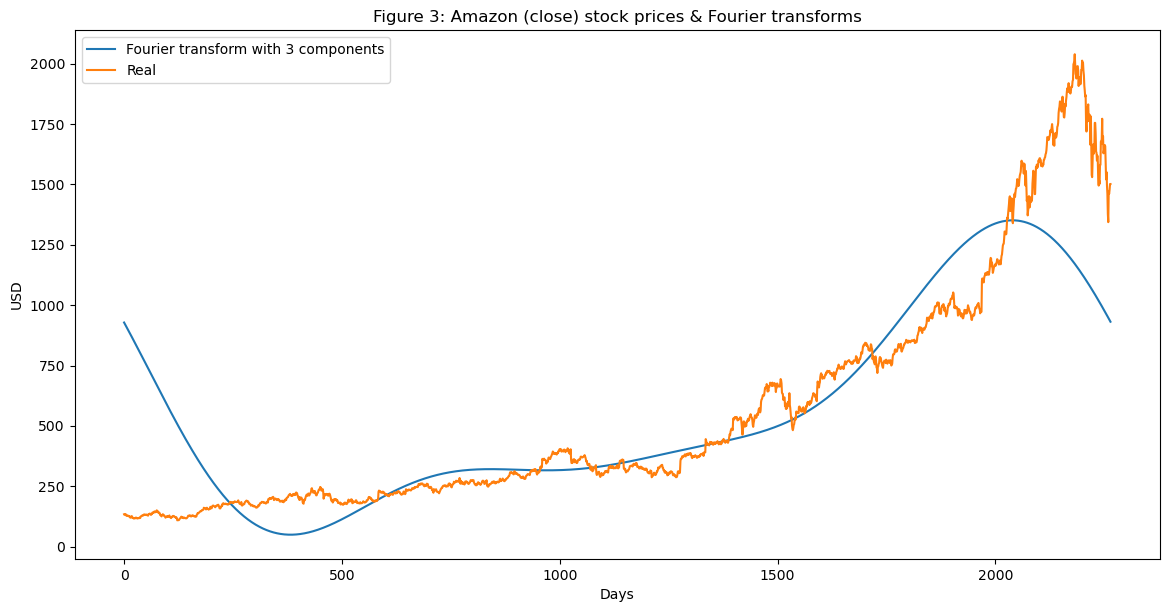

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


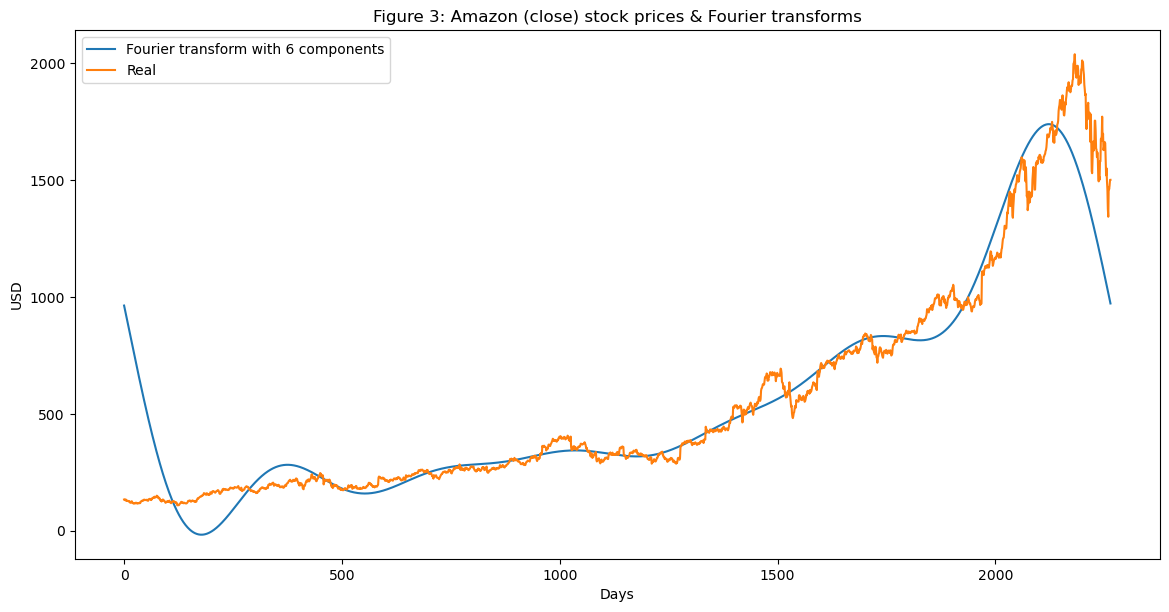

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


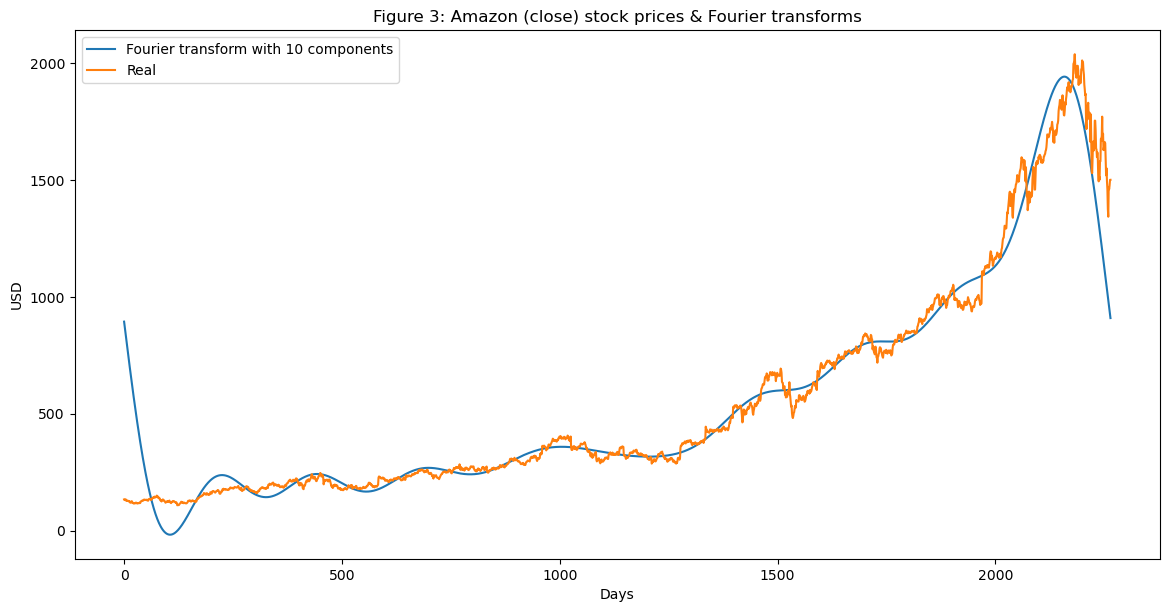

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


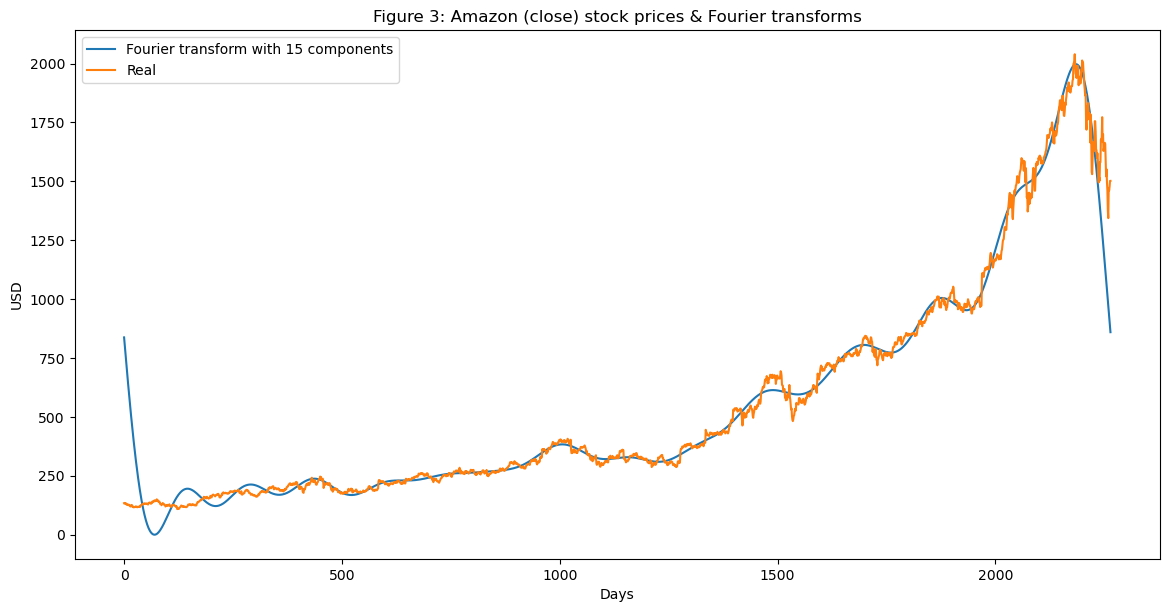

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


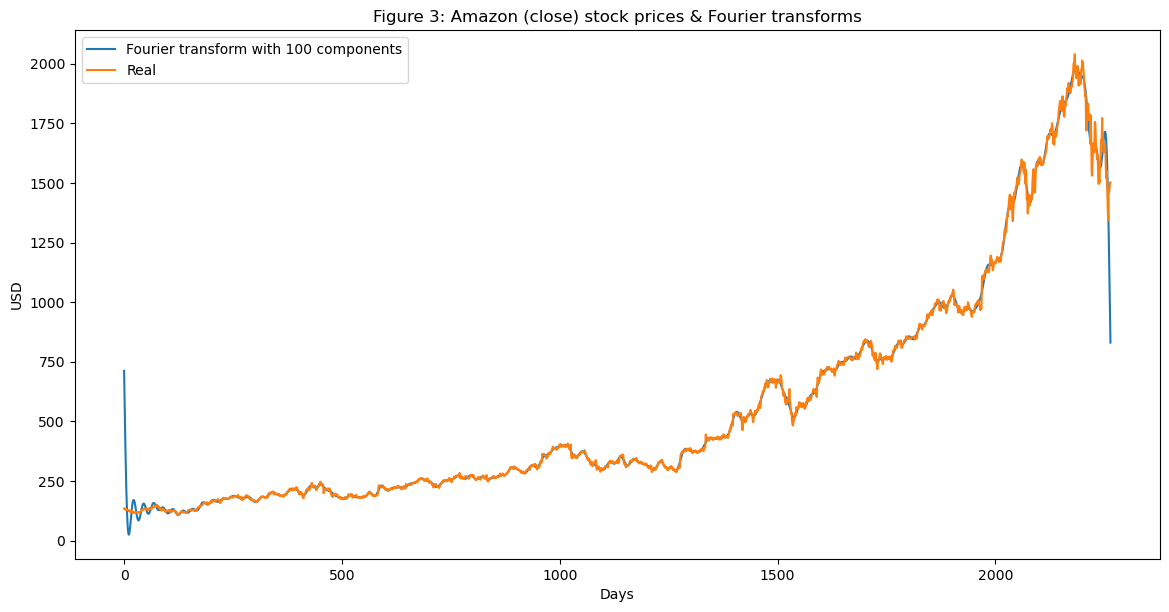

In [279]:
# plot fft
def plot_fft(data,column,figsize=(14,7),fft_levels=[3,6,10,15,100]):
    if 'fft' not in data.columns:
        raise ValueError('the input dataset does not have a fft column.')
        
        
    for num in fft_levels:
        fft_list=np.asarray(data['fft'].tolist());
        fft_list[num:-num]=0
        fig=plt.figure(figsize=figsize, dpi=100)
        plt.plot(np.fft.ifft(fft_list),label='Fourier transform with {} components'.format(num))

        plt.plot(data['Close'],label='Real')
        plt.xlabel('Days')
        plt.ylabel('USD')
        plt.title('Figure 3: Amazon (close) stock prices & Fourier transforms')
        plt.legend()
        plt.show()
        
plot_fft(fft_result,'Close')

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


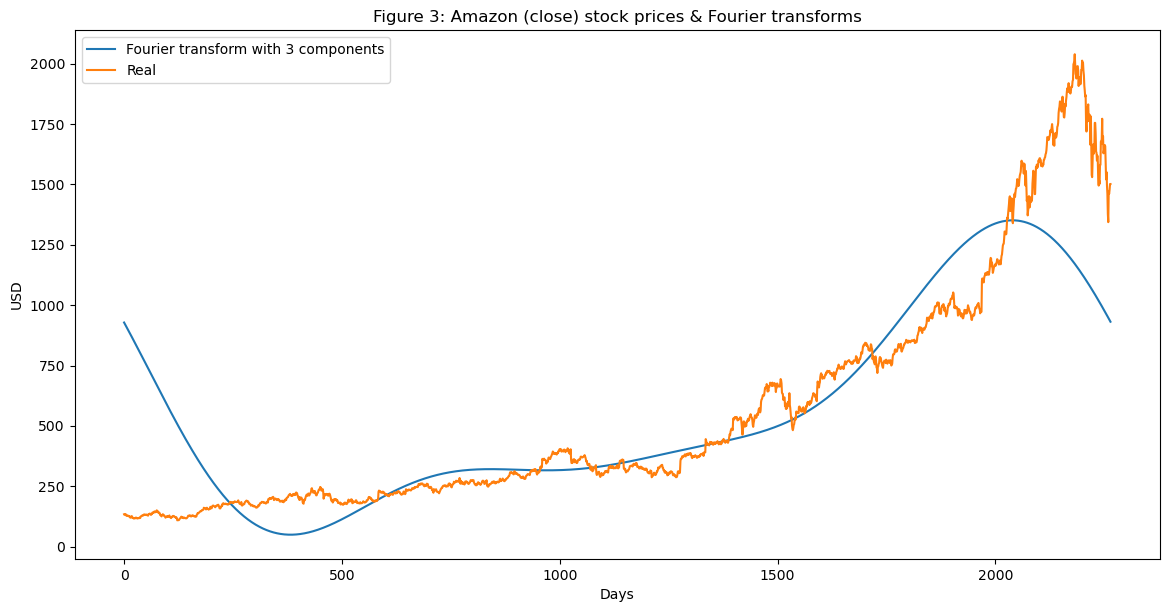

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


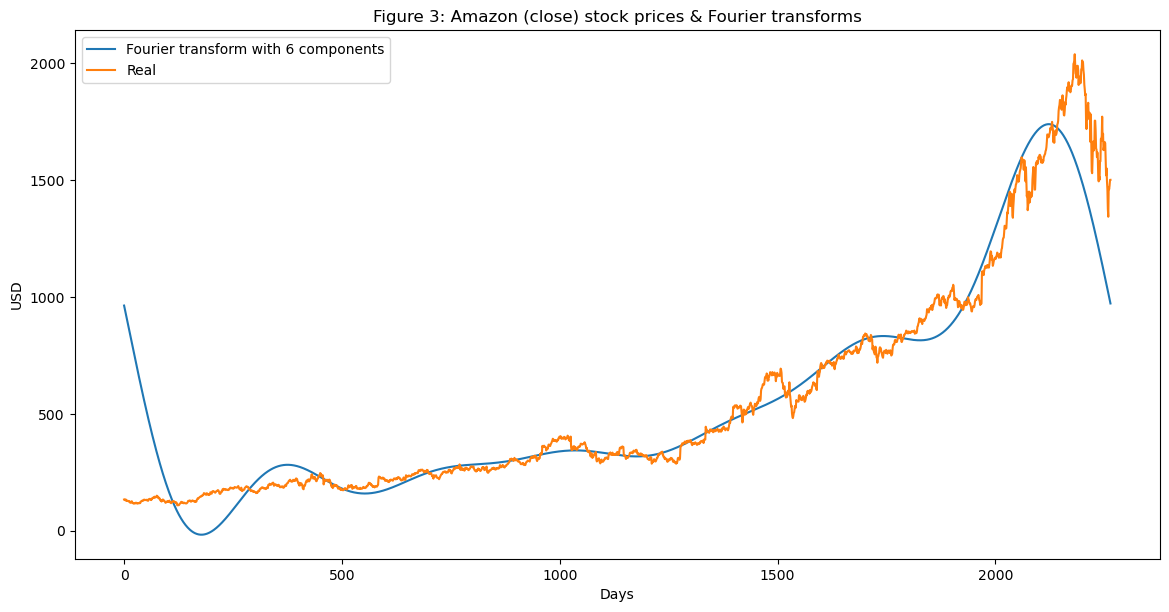

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


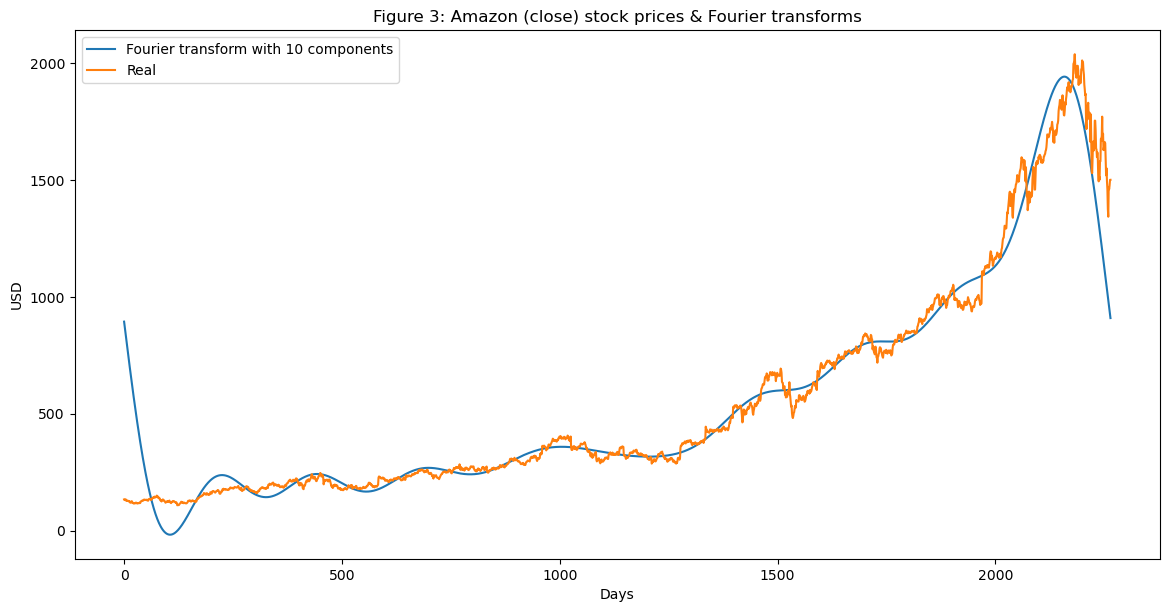

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


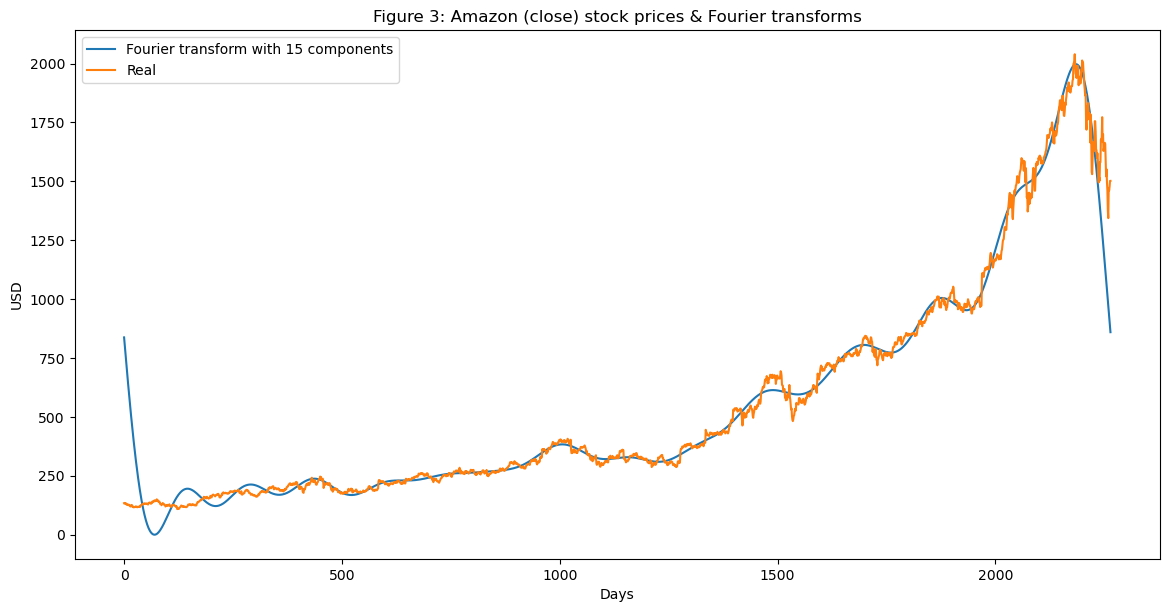

c:\users\sheyda\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


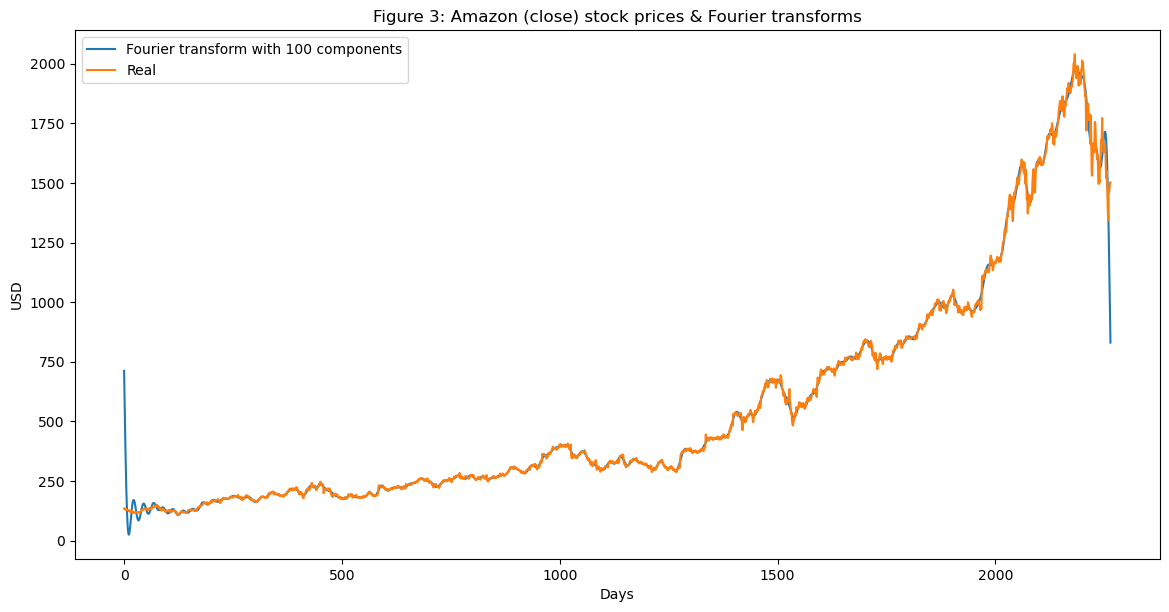

more fourier transform components => better estimation. Fourier transform can be quite useful to detect many charactristics of timeseries such as seasonality. but it is more useful for simple problems. Also if we look for feature extraction, we can use the fourier transform as it naturally will have strong correlation with target.

## SARIMAX

from seasonal decompostion plots we now know that our data is seasonal. Therefore, instead of simple ARIMA, we go for its seasonal version and use SARIMAX to develope a predictive model for our time-series.

SARIMAX is defined as SARIMA(p,d,q)x(P,D,Q,S), if you don't know the meaning of either of these parameters please check them out here: https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

Needless to say, different values of SARIMA parameters can result in predictions with variant quality. To determine their value we first use  ACF and PACF plots.

In [261]:
# to get a more clear picture of data features in acf and pacf first resample data (decrease granularity)
df.fillna(0)
train_resample=df.resample('M', on='Date').mean()

In [263]:
#lets put the last 30 observations aside for test (you can change the size of train/test set as you prefer)
train_set=train_resample['Open'][:-30].values

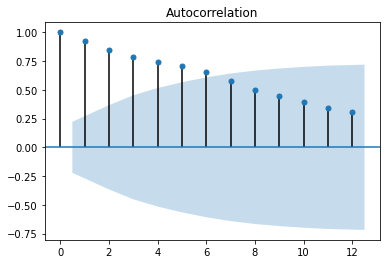

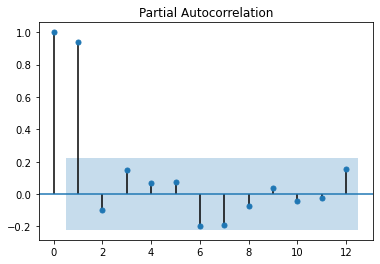

In [290]:
fig = sm.graphics.tsa.plot_acf(train_set, lags=12)
fig = sm.graphics.tsa.plot_pacf(train_set, lags=12)


we can see that at 1 we have a positive spike therefore p=P=1, d=D=1 for first difference,q=Q=6/7 because there are two negative spikes in the plot, and s=12 (monthly) 

In [336]:
def apply_sarimax(data,column,p=1,d=1,q=1,P=1,D=1,Q=1,s=12):
    """
    Plot SARIMAX prediction for train set
    
    input
    data (pd.dataframe) : Dataframe with date index and containing input "column"
    column (string) : the name of the column whose value we want to predict
    p,d,q,P,D,Q,s (int) : sarimax parameters  
    
    output
    predictions (pd.dataframe): index= date, yhat= model's prediction
    model_fit (statmodels.sarimax) : the developed sarima model fit on the data
    """
    
    # check input validity
    assert data.index.dtype == 'datetime64[ns]','The input data should have DateTime index'
    assert column in data.columns,'The input data does not have a column named %s'%column
    
    # define model
    model = SARIMAX(data['Close'], order=(p,d,q), seasonal_order=(P,D,Q,s))
    # fit model
    model_fit = model.fit()

    # Predict
    yhat = model_fit.predict()
    predictions=pd.DataFrame(yhat,columns=['yhat'])

    # Plot predictions and real values
    y=data[column]
    plt.figure(figsize=(14,10))
    plt.plot(y)
    plt.plot(predictions)
    plt.title("Prediction for SARIMA({},{},{})({},{},{},{})".format(p,d,q,P,D,Q,s))
    plt.xlabel('years')
    plt.ylabel('Average close price');
    return predictions, model_fit

if you want to plot all in one figure, you can save the result of each line below as a column in a dataframe and then use
plot function defined directly on the pandas dataframe to plot all trends in one figure: e.g.: df.plot()

c:\users\sheyda\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
c:\users\sheyda\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\sheyda\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\sheyda\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\sheyda\anaconda3\lib\site-packages\statsmodels\base\model.py:568: Convergen

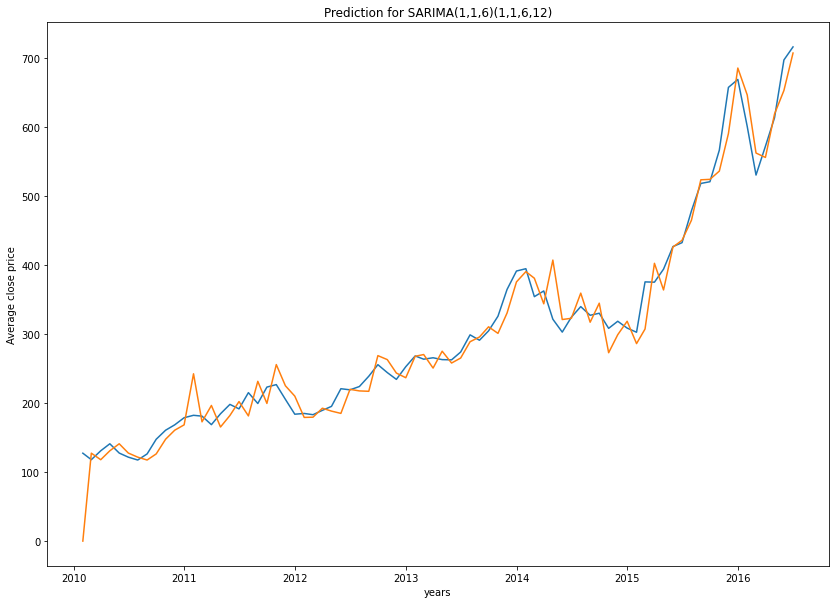

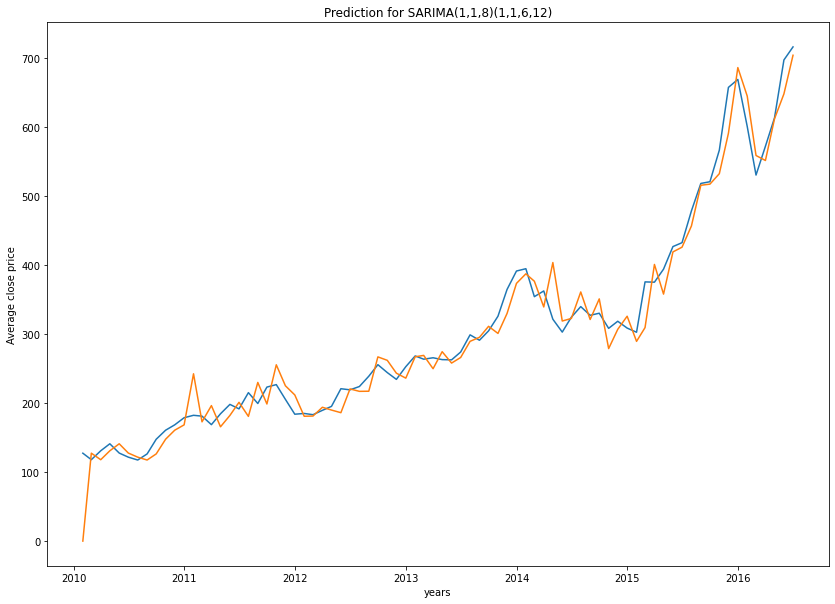

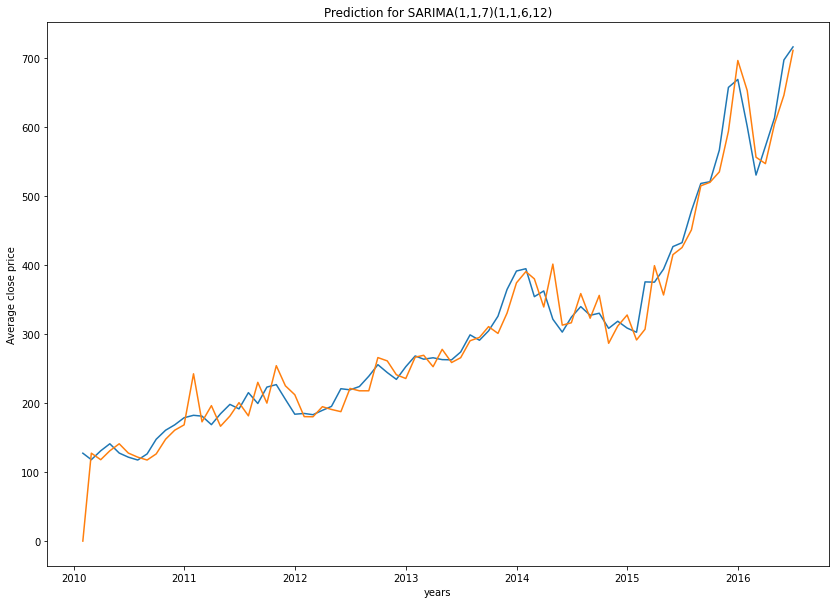

In [400]:
#predict only for train set
predictions1,model1=apply_sarimax(data= train_resample[:-30],column='Close',q=6,Q=6,s=12)
predictions2,model2=apply_sarimax(data= train_resample[:-30],column='Close',q=8,Q=6,s=12)
predictions3,model3= apply_sarimax(data= train_resample[:-30],column='Close',q=7,Q=6,s=12)

### evaluate models

we checked 3 different parameter sets for sarima and got 3 models in return. We also provided a visualization for each of the models and their performance. However, it is often difficult to evaluate a model visually. so we are going to check AIC for each model to mathematically show which setting results in more accurate model.

In [401]:
models=[model1,model2,model3]
params= [[1,1,6,1,1,6,12],[1,1,8,1,1,8,12],[1,1,7,1,1,7,12]]

In [402]:
for ctr,model in enumerate(models):
    print('SARIMA{} - AIC:{}'.format(params[ctr], model.aic))

SARIMA[1, 1, 6, 1, 1, 6, 12] - AIC:643.1567062829671
SARIMA[1, 1, 8, 1, 1, 8, 12] - AIC:646.360676155192
SARIMA[1, 1, 7, 1, 1, 7, 12] - AIC:644.5832294890845


So of all the combinations we checked for parameters p,d,q,P,D,Q,s, [1, 1, 6, 1, 1, 6, 12] is the best as it results in minimum AIC compared to the others.

If you have decided to use SARIMA model for you analysis, we highly recommend you to use a grid search approach and choose the combination that works best for your case (least AIC).

### apply model on testset (the last 30 months)

In [403]:
# choosing the model with least AIC
final_model= model1
final_prediction= predictions1

#predict future using get_forcat()
yhat_test=pd.DataFrame(final_model.get_forecast(steps=30).summary_frame()['mean'])

In [404]:
# concat test and train predictions
yhat_test.rename({'mean':'yhat'},axis=1,inplace=True)
predictions=pd.concat([final_prediction,yhat_test])

In [405]:
real_val=pd.DataFrame(train_resample['Close'])

''

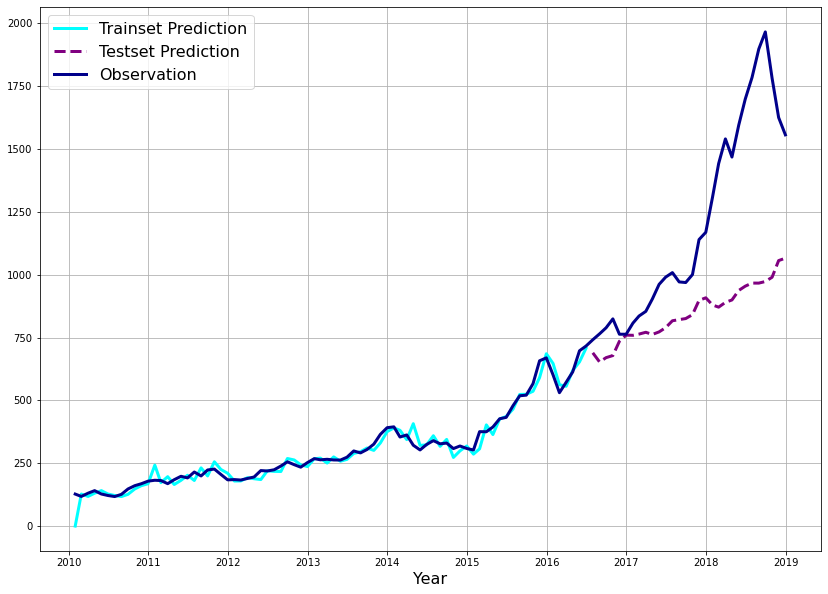

In [413]:
plt.figure(figsize=(14,10))
plt.plot(predictions[:-30],label='Trainset Prediction',lw=3,color='cyan')
plt.plot(predictions[-30:],label='Testset Prediction',ls='--',lw=3,color='purple')
plt.plot(real_val,label='Observation',lw=3,color='darkblue')
plt.legend(fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.legend(fontsize=16)
plt.grid()
;

model can predict the upward trend until mid 2018, but the prediction of values is far from desired and from mid 2018 onward the decrease in stock is completely missed out. There are still works we could do to improve the accuracy of SARIMA (such as better choice in its parameters) but here I want to move on to the applications of neural networks in time-series analysis.